# HMM

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bidict

import literate
import HMM2 as HMM

In [2]:
syldict = literate.syldict("data/Syllable_dictionary.txt")
data, words = literate.read("data/shakespeare.txt", syldict)
rhymes = literate.get_rhymes(data)

print(len(data), "sonnets\n",
      len(words), "unique words\n",
      len(syldict), "words in dictionary\n",
      len(rhymes), "rhyming words")

154 sonnets
 3205 unique words
 3205 words in dictionary
 1015 rhyming words


In [3]:
wmap = bidict.bidict(enumerate(words)).inv

In [4]:
def toNum(wmap, words):
    return [wmap[w] for w in words]

def toWord(wmap, nums):
    return [wmap.inv[i] for i in nums]

def squash(sonnet):
    return [w for l in sonnet for w in l]

## Training

In [5]:
nummed = [toNum(wmap, squash(s)) for s in data]
scores = np.array([])
hmm = HMM.init_rand(10, len(words))

In [6]:
hmm,s = HMM.unsupervised(nummed, N_iters=5, hmm=hmm)
scores = np.concatenate([scores, s])

Training 5 iters
0  1  2  3  4  
elapsed 27.607454776763916


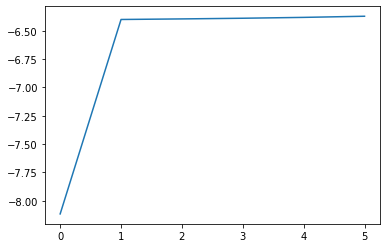

In [7]:
plt.plot(scores)

import pickle
with open("10s-50i.pck", "wb") as f:
    pickle.dump(hmm, f)

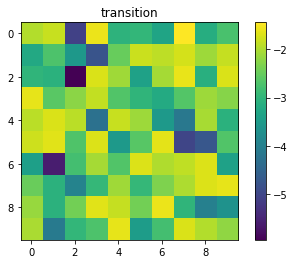

In [8]:
plt.title("transition")
plt.imshow(np.log(hmm.A))
plt.colorbar()

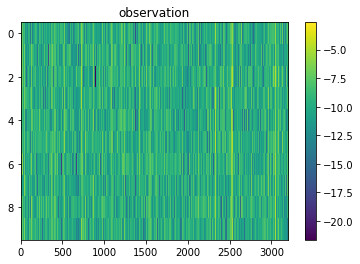

In [9]:
plt.title("observation")
plt.imshow(np.log(hmm.O), aspect='auto')
plt.colorbar()

In [10]:
HMM.probability_alphas(hmm, nummed[0], log=True)

-697.5647023153182

## Generation

In [11]:
em, st = HMM.generate_emission(hmm, 140)

def sonnetify(wmap, syldict, ids):
    """take string of word ids,
    convert them to words,
    and break lines every 10 ish syllables
    """
    sonnet = []
    line = []
    syls = 0
    for i in ids:
        word = wmap.inv[i]
        syls += abs(syldict[word][0])
        line.append(word)
        if (syls >= 10):
            sonnet.append(line)
            line = []
            syls = 0
            if (len(sonnet) == 14):
                break
    return sonnet

literate.recite(sonnetify(wmap, syldict, em))

but didst thou it your a me if those be
wood stealing shall morning i of hear her
thou and thoughts control look can that be as
from these thy farther self far in tresses
shall adverse are might addition when the
the for in men pass you melancholy spent
youth under accents created living others
spite hide love's that read keen thy with love but
methinks and thou lour'st lovely laid votary
doom now show for married not be that self
at no what still my self-same more thine lips
fresh more i breathe wits thou and i in summer
this rehearse of pen thy least will there and
if move the you costly unknown upon


In [12]:
def wordmask(wmap, condition):
    """creates a len(words) array that is True
    for words satisfing the condition
    """
    mask = np.repeat(False, len(wmap))
    filtered = [wmap[w] for w in wmap if condition(w)]
    mask[filtered] = True
    return mask
    

In [13]:
def generate_sonnet(hmm, wmap, rhymes, syldict):
    '''
    Generates sonnet using hmm

    Returns:
        emission:   The randomly generated sonnet as a list of words
    '''
    state = np.random.choice(hmm.L, p=hmm.A0)
    
    # functions to filter down allowable words
    def fewersyls(n, w):
        return abs(syldict[w][0]) < n
    def hassyls(n, w):
        return abs(syldict[w][0]) == n
    def rhymable(w):
        return len(rhymes[w]) > 0
    def rhymeswith(word, w):
        return w in rhymes[word]
    
    def try_line(state, rhymeword=None, maxwords=20):
        """Generate new line starting with given state,
        having 10 syllables, ending on a rhymable word if rhymeword is None,
        and ending on a rhyme with rhymeword if it is a string.
        It unfortunately often gets stuck generating th'.
        """
        syls = 10
        line = []
        while (syls > 0):
            if (len(line) > maxwords):
                break
            # if a word either has few enough syllables to not end the line,
            # or ends the line and satisfies the rhyme scheme.
            # If there is no rhymeword, it must be rhymable, otherwise,
            # it must rhyme with rhymeword.
            sylrhyme = lambda w: fewersyls(syls, w)\
                or (hassyls(syls, w) and (rhymeswith(rhymeword, w) if rhymeword else rhymable(w)))
            
            # filter out words by setting their probabilities to zero
            pobs = hmm.O[state].copy()
            pobs[~wordmask(wmap, sylrhyme)] = 0
            pobs /= pobs.sum()

            # pick new word and state
            word = wmap.inv[np.random.choice(hmm.D, p=pobs)]
            state = np.random.choice(hmm.L, p=hmm.A[state])
            line.append(word)
            syls -= abs(syldict[word][0])
            #print(syls, word, rhymeword, sum(pobs!=0))
        return state, line
    
    def generate_line(state0, rhymeword=None, maxwords=20, tries=100):
        """Keeps re-running try_line until it generates something valid"""
        for _ in range(tries):
            state, line = try_line(state0, rhymeword, maxwords)
            if (len(line) < maxwords):
                return state,line
        # we tried our best
        return state,line

    sonnet = []
    # make three quadtrains, with rhyme scheme abab
    for q in range(3):
        state, line = generate_line(state)
        sonnet.append(line)
        state, line = generate_line(state)
        sonnet.append(line)
        state, line = generate_line(state, sonnet[-2][-1])
        sonnet.append(line)
        state, line = generate_line(state, sonnet[-2][-1])
        sonnet.append(line)
    # and a rhyming couplet
    state, line = generate_line(state)
    sonnet.append(line)
    state, line = generate_line(state, sonnet[-1][-1])
    sonnet.append(line)

    return sonnet

In [14]:
sonnet = generate_sonnet(hmm, wmap, rhymes, syldict)
literate.recite(sonnet)

wherefore against some breathe gives been is not
when but who welcome seconds eye put'st looks
have case hath are her with precious to plot
sworn could who at a day or of and th' th' th' th' th' th' th' th' hooks
the read my heart is divining learn time
so the consider seen man of whether was
me which take old addition for rose th' rhyme
looking was since stage shape thy your eye pass
had away love me heart's a ill are fleet'st
the the of loss past striving who no please
do and and my i all to were at sweets
stop it nothing of is for i beauty th' th' t' th' th' th' t' th' th' th' t' th' th'
lays thou his he virtue purpose report
me you unlooked therefore why child to sport


## visualization

In [15]:
# coming soon